In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import MinMaxScaler

from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

In [ ]:
def print_metrics(y_true, y_pred, y_prob):
    print("\n📌 Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"✅ Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"✅ Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"✅ F1-score: {f1_score(y_true, y_pred):.4f}")
    print(f"✅ ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\n📌 Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

In [ ]:
loan_data_backup = pd.read_csv('/content/drive/MyDrive/fin_credit/loan_data_inputs_train.csv')

In [ ]:
loan_data = loan_data_backup.copy()
pd.options.display.max_columns = None
loan_data.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,earliest_cr_line_date,mths_since_earliest_cr_line,term_int,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d_factor,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate_factor,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,funded_amnt_f

### preprocessing

In [ ]:
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years', '',regex=True)
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].fillna('0')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])


In [ ]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')
loan_data['mths_since_earliest_cr_line'] = (
    (pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']).dt.days / 30.44
).round()
loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['mths_since_earliest_cr_line'].max()

<ipython-input-8-503666818867>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['mths_since_earliest_cr_line'].max()
<ipython-input-8-50366681

In [ ]:
loan_data['term_int'] = loan_data['term'].str.replace(' months', '')
loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace(' months', ''))

In [ ]:
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')


loan_data['mths_since_issue_d'] = (
    (pd.to_datetime('2017-12-01') - loan_data['issue_d_date']).dt.days / 30.44
).round()

In [ ]:
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)

loan_data['y'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                       'Does not meet the credit policy. Status:Charged Off',
                                                       'Late (31-120 days)']), 0, 1)

<ipython-input-11-d24b19fc27a8>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)
<ipython-input-11-d24b19fc27a8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

### data selection

In [ ]:
df = loan_data.loc[: , ['grade',
'home_ownership',
#'addr_state',
'verification_status',
'purpose',
'initial_list_status',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'int_rate',
'mths_since_earliest_cr_line',
'delinq_2yrs',
'inq_last_6mths',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim',
'annual_inc',
'dti',
'y'
]]

### modeling

#### 1. LightGBM

In [ ]:
df.head()

,grade,home_ownership,verification_status,purpose,initial_list_status,term_int,emp_length_int,mths_since_issue_d,int_rate,mths_since_earliest_cr_line,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim,annual_inc,dti,y
0,A,MORTGAGE,Source Verified,debt_consolidation,f,36,3,45.0,8.90,372.0,0.0,1.0,20.0,0.0,32.0,0.0,57000.0,77000.0,21.91,1
1,C,MORTGAGE,Not Verified,debt_consolidation,f,36,6,64.0,14.33,240.0,1.0,2.0,15.0,0.0,38.0,0.0,10000.0,112000.0,7.49,1
2,A,MORTGAGE,Verified,debt_consolidation,f,36,10,54.0,8.90,317.0,0.0,1.0,9.0,0.0,20.0,0.0,33300.0,84000.0,14.83,1
3,D,RENT,Source Verified,debt_consolidation,f,36,7,44.0,16.59,230.0,1.0,3.0,9.0,0.0,13.0,0.0,12500.0,43000.0,13.68,0
4,C,MORTGAGE,Verified,educational,f,36,5,101.0,12.84,233.0,0.0,1.0,14.0,0.0,30.0,0.0,8400.0,94000.0,22.54,0


In [ ]:
X = df.drop(columns='y')
y = df['y']

# minmaxscaler
numeric_features = X.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# onehotencoding
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [-1, 3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
}

grid_search = GridSearchCV(
    LGBMClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 ROC AUC:", grid_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 232574, number of negative: 28545
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 261119, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.890682 -> initscore=2.097727
[LightGBM] [Info] Start training from score 2.097727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [ ]:
best_lgbm = grid_search.best_estimator_

y_pred_prob = best_lgbm.predict_proba(X_val.values)
y_pred_best = (y_pred_prob[:, 1] >= 0.9).astype(int)

print_metrics(y_val,y_pred_best,y_pred_prob[:,1])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



📌 Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.73      0.28     12233
           1       0.94      0.56      0.71     99676

    accuracy                           0.58    111909
   macro avg       0.56      0.65      0.49    111909
weighted avg       0.86      0.58      0.66    111909

✅ Accuracy: 0.5819
✅ Precision: 0.9442
✅ Recall: 0.5639
✅ F1-score: 0.7061
✅ ROC AUC: 0.7037

📌 Confusion Matrix:
[[ 8911  3322]
 [43469 56207]]


In [ ]:
import pickle

with open('/content/drive/MyDrive/fin_credit/model/best_lgbm_model.pkl', 'wb') as f:
    pickle.dump(best_lgbm, f)

In [ ]:
import pickle

with open('/content/drive/MyDrive/fin_credit/model/best_lgbm_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

##### SHAP

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


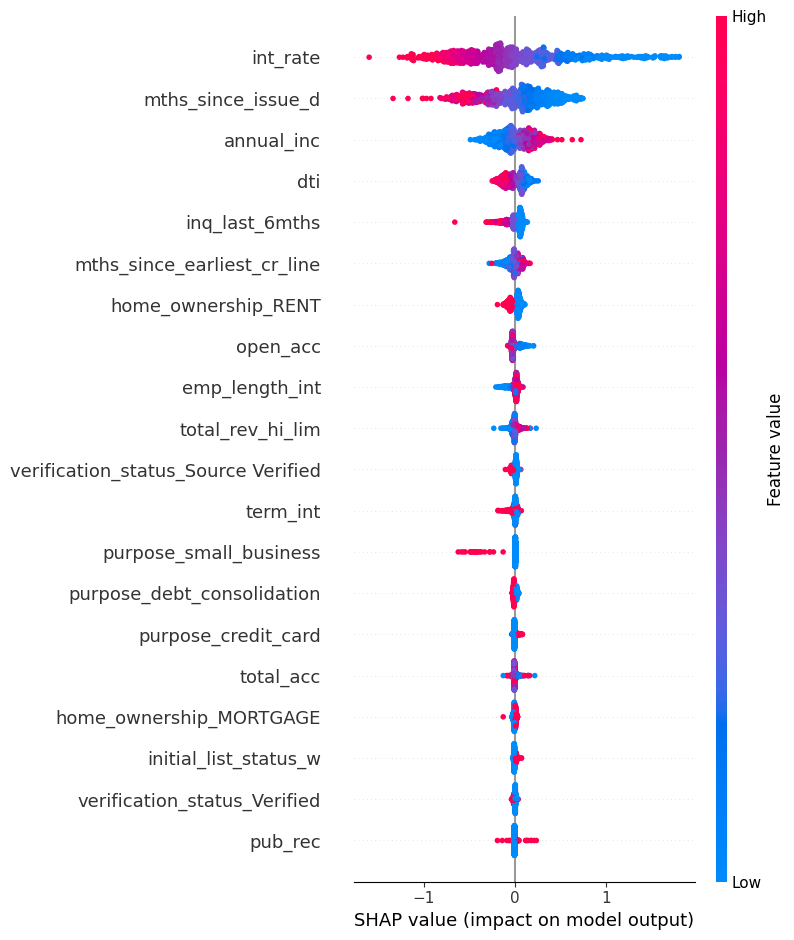

In [ ]:
import shap

explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_val[:1000])

shap.summary_plot(shap_values, X_val[:1000])

In [ ]:
shap.initjs()

sample_idx = 0

shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_val[:1000].iloc[sample_idx, :],
    feature_names=feature_names,
    link="logit"  # 확률(0~1)로 변환
)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_val[:1000],link="logit")

Output hidden; open in https://colab.research.google.com to view.

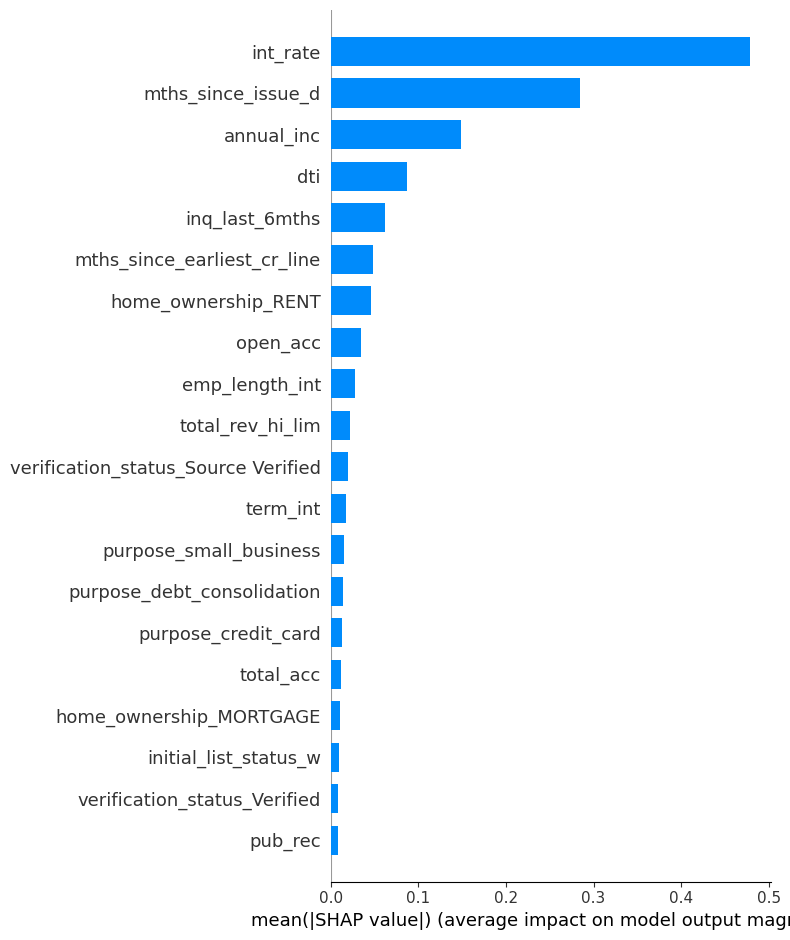

In [ ]:
shap.summary_plot(shap_values, X_val[:1000], plot_type = "bar")

##### lime

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_val[:1000].values,
    mode='classification',
    feature_names=X_val.columns,
    class_names=[0, 1],
    discretize_continuous=True
)

exp = explainer.explain_instance(X_val.values[0], best_lgbm.predict_proba, num_features=10)

exp.show_in_notebook(show_all=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_val[:1000].values,
    mode='classification',
    feature_names=X_val.columns,
    class_names=[0, 1],
    discretize_continuous=True
)

exp = explainer.explain_instance(X_val.values[20], best_lgbm.predict_proba, num_features=10)

exp.show_in_notebook(show_all=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### 2. smote

In [ ]:
X = df.drop(columns='y')
y = df['y']

categorical_columns = X.select_dtypes(include=['object', 'category']).columns
categorical_column_indexes = [i for i, col in enumerate(categorical_columns)]
print(categorical_column_indexes)


[0, 1, 2, 3, 4]


In [ ]:
print(X.shape,y.shape)

(373028, 19) (373028,)


In [ ]:
numeric_features = X.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

In [ ]:
X.shape

(373028, 19)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
smote_nc = SMOTENC(categorical_features=categorical_column_indexes, sampling_strategy=0.3, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

In [ ]:
print(X_train_resampled.shape,y_train_resampled.shape)

(302346, 19) (302346,)


In [ ]:
X_combined = pd.concat([X_train_resampled, X_val], axis=0)

X_combined_encoded = pd.get_dummies(X_combined, columns=categorical_columns, drop_first=True)

X_train_encoded = X_combined_encoded.iloc[:len(X_train_resampled), :]
X_val_encoded = X_combined_encoded.iloc[len(X_train_resampled):, :]

In [ ]:
print(X_train_encoded.shape,X_val_encoded.shape)

(302346, 41) (111909, 41)


In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [-1, 3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
}

grid_search = GridSearchCV(
    LGBMClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_encoded, y_train_resampled)

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 ROC AUC:", grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 232574, number of negative: 69772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3117
[LightGBM] [Info] Number of data points in the train set: 302346, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.769231 -> initscore=1.203976
[LightGBM] [Info] Start training from score 1.203976
최적 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'subsample': 0.8}
최고 ROC AUC: 0.8645322778064465


In [ ]:
best_xgb = grid_search.best_estimator_

y_pred_prob = best_xgb.predict_proba(X_val_encoded.values)
y_pred_best = (y_pred_prob[:, 1] >= 0.9).astype(int)

print_metrics(y_val,y_pred_best,y_pred_prob[:,1])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



📌 Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.78      0.27     12233
           1       0.95      0.50      0.65     99676

    accuracy                           0.53    111909
   macro avg       0.56      0.64      0.46    111909
weighted avg       0.86      0.53      0.61    111909

✅ Accuracy: 0.5287
✅ Precision: 0.9494
✅ Recall: 0.4974
✅ F1-score: 0.6528
✅ ROC AUC: 0.6995

📌 Confusion Matrix:
[[ 9589  2644]
 [50096 49580]]
